In [131]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from models import *

In [132]:
models_path = {
    "pacman#1": "wandb/run-20220620_172122-1x7pl97x/files/MsPacmanNoFrameskip-v4.pt",
    "pacman#2": "wandb/run-20220621_121131-72ur8wjv/files/MsPacmanNoFrameskip-v4.pt",
    "pacman#3": "wandb/run-20220622_111625-2ke0zp2g/files/MsPacmanNoFrameskip-v4.pt",
    "pacman#4": "wandb/run-20220623_163619-zvj29l2h/files/MsPacmanNoFrameskip-v4.pt",
    "pacman#5": "wandb/run-20220623_205420-11muekni/files/MsPacmanNoFrameskip-v4.pt",
    "pong#1": "wandb/run-20220621_004915-2c4cnfag/files/PongNoFrameskip-v4.pt",
    "pong#2": "wandb/run-20220621_121112-v6xnp2xm/files/PongNoFrameskip-v4.pt",
    "pong#3": "wandb/run-20220622_111655-12zmxeww/files/PongNoFrameskip-v4.pt",
    "pong#4": "wandb/run-20220623_163543-34u2d8d0/files/PongNoFrameskip-v4.pt",
    "pong#5": "wandb/run-20220623_205541-23zjio3t/files/PongNoFrameskip-v4.pt",
    "pong#6": "wandb/run-20220623_222809-1iu7ueol/files/PongNoFrameskip-v4.pt"
}

In [133]:
batch_size = 32
image_channels = 3
k = 4
ENV = "PongNoFrameskip-v4" # "MsPacmanNoFrameskip-v4"
data_path = f"data/{ENV}"
traj_idx = 70

encoder = Encoder(image_channels)
key_net = KeyNet(image_channels, k)
refine_net = RefineNet(image_channels)

model = Transporter(encoder, key_net, refine_net)
model_path = models_path["pong#4"]
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval(); #; suppress output

In [134]:
from dataset import Dataset, Sampler
from torchvision import transforms

transform = transforms.ToTensor()
dataset = Dataset(data_path, transform=transform)
sampler = Sampler(dataset)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, sampler=sampler)

model.eval()
for xt, xtp1 in loader:
    break
    
target_keypoints = model.key_net(xtp1)
reconstruction = model(xt, xtp1)

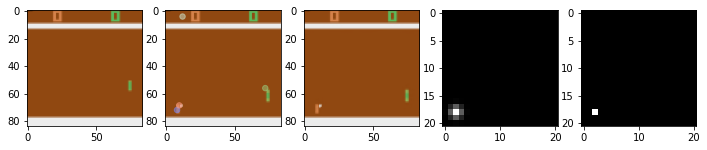

In [135]:
from matplotlib.patches import Circle
from utils import get_n_colors

fig, ax = plt.subplots(1, 5, figsize=(12, 4))
idx = 12
k_idx = 1
std = 0.1

feature_maps = spatial_softmax(target_keypoints)
gmap = gaussian_map(feature_maps, std)[idx, k_idx]

ax[0].imshow(xt[idx].permute([1, 2, 0]).detach().numpy(), cmap='gray')
ax[1].imshow(xtp1[idx].permute([1, 2, 0]).detach().numpy())
ax[2].imshow(reconstruction[idx].permute([1, 2, 0]).detach().numpy())
ax[3].imshow(gmap.detach().numpy(), cmap='gray', vmin=0, vmax=1)
ax[4].imshow(feature_maps[idx, k_idx].detach().numpy(), cmap='gray')

locs = compute_keypoint_location_mean(
    spatial_softmax(model.key_net(xtp1)))[idx]

colors = get_n_colors(len(locs))
for i, l in enumerate((locs + 1) / 2 * 80):
    ax[1].add_patch(Circle((l[1].item(), l[0].item()), 2, 
                           color=colors[i], alpha=0.5))

In [136]:
from PIL import Image, ImageDraw

def get_keypoints(model, source_images):
    return compute_keypoint_location_mean(
        spatial_softmax(model.key_net(source_images)))

def annotate_keypoints(img, kp_t, colors):
    draw = ImageDraw.Draw(img)

    for i, kp in enumerate(unnormalize_kp(kp_t, image_width)):
        y = kp.detach().numpy()[0]
        x = kp.detach().numpy()[1]
        r = 2
        draw.ellipse((x-r, y-r, x+r, y+r), tuple(colors[i]))
    
    return img

def unnormalize_kp(kp, img_width):
    return (kp + 1) / 2 * img_width

traj = torch.stack(dataset.get_trajectory(traj_idx))
keypoints = get_keypoints(model, traj)
image_width = traj.size(-1)

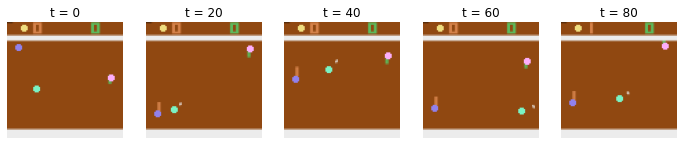

In [137]:
fig = plt.figure(figsize=(12, 3))

colors = get_n_colors(k)
colors = [(int(color[0] * 255), int(color[1]*255), int(color[2]*255), 255) for color in colors]
for i, t in enumerate(range(0, 100, 20)):
    frame_t = traj[t].permute([1, 2, 0])
    kp_t = keypoints[t]
    im = Image.fromarray((frame_t.detach().numpy() * 255).astype('uint8'))
    annotate_keypoints(im, kp_t, colors)
    im = np.array(im)
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(im)
    ax.set_axis_off()
    ax.set_title('t = {}'.format(t))

In [138]:
from PIL import Image, ImageDraw

traj = torch.stack(dataset.get_trajectory(traj_idx))
keypoints = get_keypoints(model, traj)
image_width = traj.size(-1)

def get_heatmaps(model, source_images, normalize=True):
    if normalize:
        return spatial_softmax(model.key_net(source_images))
    return model.key_net(source_images)

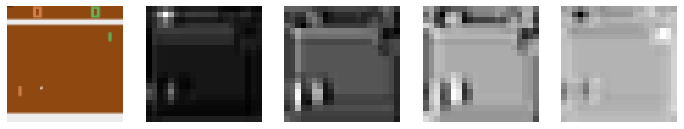

In [139]:
fig, ax = plt.subplots(1, k+1, figsize=(12, 3))

idx = 20

ax[0].imshow(traj[idx].permute([1, 2, 0]).detach().numpy())
ax[0].set_axis_off()

hm = get_heatmaps(model, traj, normalize=False)[idx].detach().numpy()

for i, m in enumerate(hm):
    ax[i+1].imshow(m, cmap='gray')
    ax[i+1].set_axis_off()

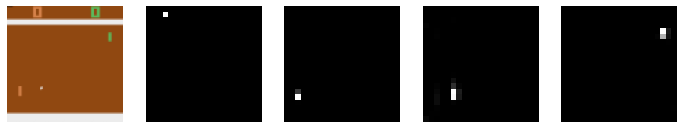

In [140]:
fig, ax = plt.subplots(1, k+1, figsize=(12, 3))

idx = 20

ax[0].imshow(traj[idx].permute([1, 2, 0]).detach().numpy())
ax[0].set_axis_off()


hm = get_heatmaps(model, traj, normalize=True)[idx].detach().numpy()

for i, m in enumerate(hm):
    ax[i+1].imshow(m, cmap='gray')
    ax[i+1].set_axis_off()